In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline


In [3]:
plt.style.use('seaborn')

# we will skip 2001 - 2005 due to bad quality

crimes1 = pd.read_csv('./input/Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('./input/Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
crimes3 = pd.read_csv('./input/Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
crimes = pd.concat([crimes1, crimes2, crimes3], ignore_index=False, axis=0)

del crimes1
del crimes2
del crimes3

print('Dataset ready..')

print('Dataset Shape before drop_duplicate : ', crimes.shape)
crimes.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
print('Dataset Shape after drop_duplicate: ', crimes.shape)

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


Dataset ready..
Dataset Shape before drop_duplicate :  (6017767, 23)
Dataset Shape after drop_duplicate:  (4336556, 23)


In [4]:
crimes.drop(['Unnamed: 0', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat', 'Location'
            
            ], inplace=True, axis=1)

In [5]:
#Let's have a look at the first 3 records and see if we see what we expect
crimes.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Latitude,Longitude
0,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,16.0,45.0,11.0,41.981913,-87.771996
1,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,3.0,20.0,42.0,41.775733,-87.611920
2,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,3.0,5.0,69.0,41.769897,-87.593671


In [6]:
# convert dates to pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)

In [7]:
# of records X # of features
crimes.shape

(4336556, 13)

In [8]:
crimes.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4336556 entries, 2006-04-02 13:00:00 to 2016-05-03 23:38:00
Data columns (total 13 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
District                float64
Ward                    float64
Community Area          float64
Latitude                float64
Longitude               float64
dtypes: bool(2), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 405.3+ MB


In [9]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'
#crimes.loc[crimes['Primary Type'].isin(type_to_change) , crimes.columns=='Primary Type'] = 'OTHER'

In [10]:
# we convert those 3 columns into 'Categorical' types -- works like 'factor' in R
crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

In [11]:
# [Dempsy] - Currently changed the type of block/district/ward/community area to Categorical for Problem 1
block_to_change  = list(crimes['Block'].value_counts()[20:].index)
crimes.loc[crimes['Block'].isin(block_to_change), crimes.columns=='Block'] = 'OTHER'
crimes['Block']                = pd.Categorical(crimes['Block'])

crimes['District']             = pd.Categorical(crimes['District'])
crimes['Ward']                 = pd.Categorical(crimes['Ward'])
crimes['Community Area']       = pd.Categorical(crimes['Community Area']) 

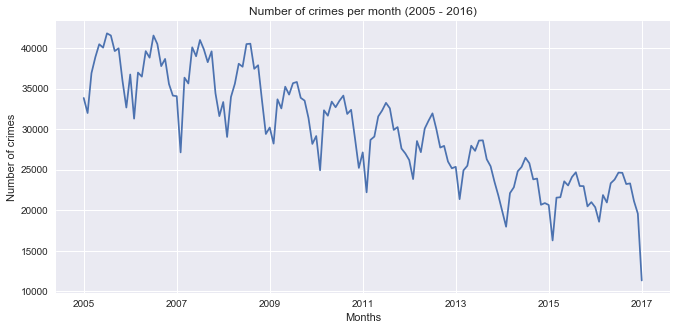

In [12]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2005 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

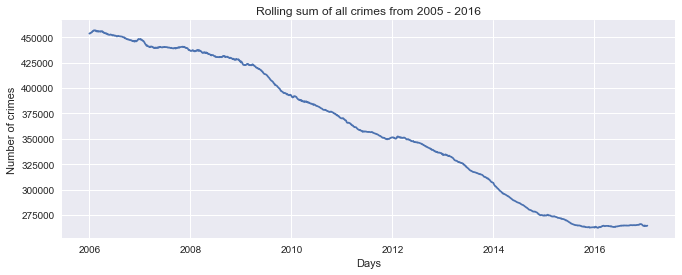

In [13]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2005 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

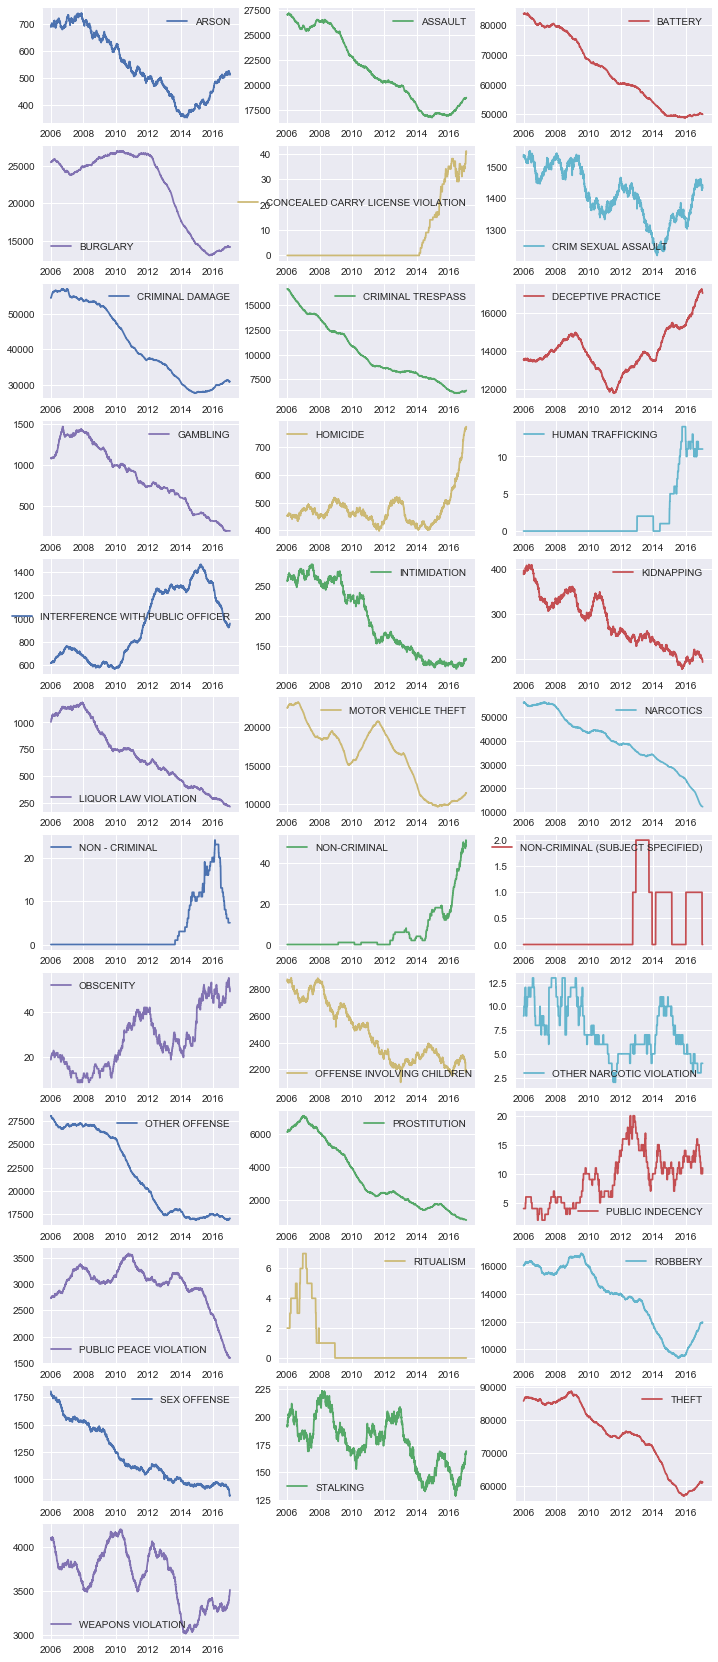

In [14]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

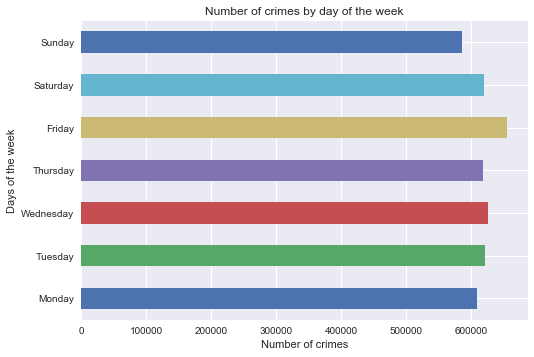

In [15]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

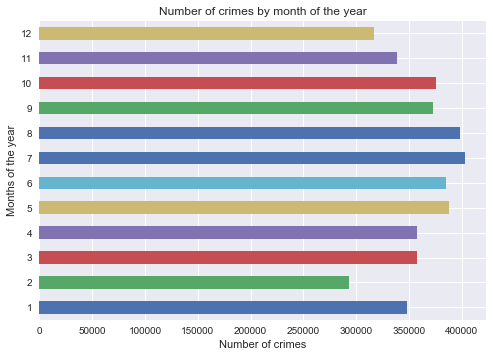

In [16]:
crimes.groupby([crimes.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()


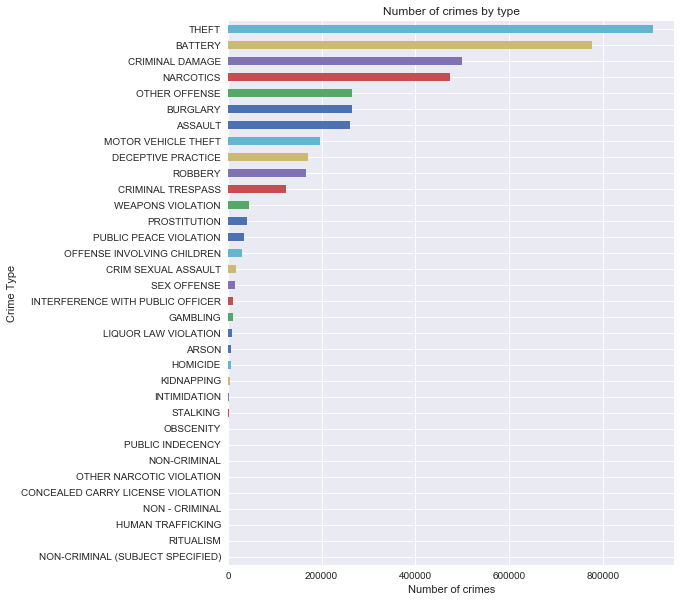

In [17]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

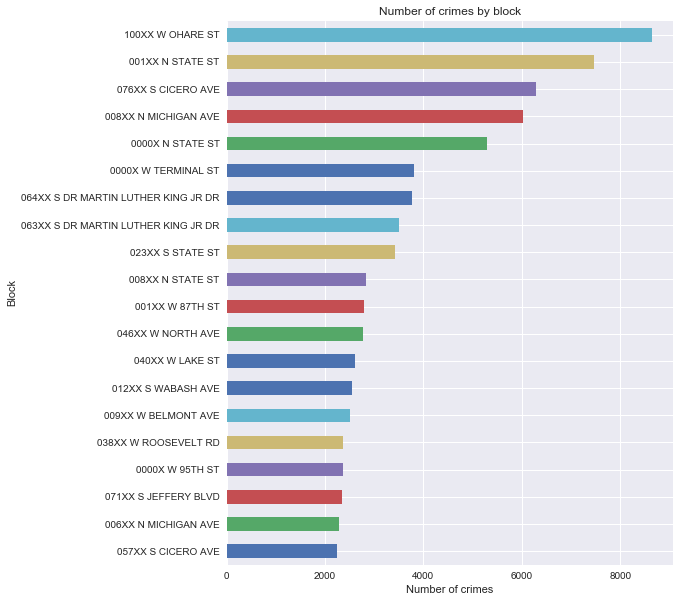

In [18]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Block']]).size().sort_values(ascending=True).head(20).plot(kind='barh')
plt.title('Number of crimes by block')
plt.ylabel('Block')
plt.xlabel('Number of crimes')
plt.show()

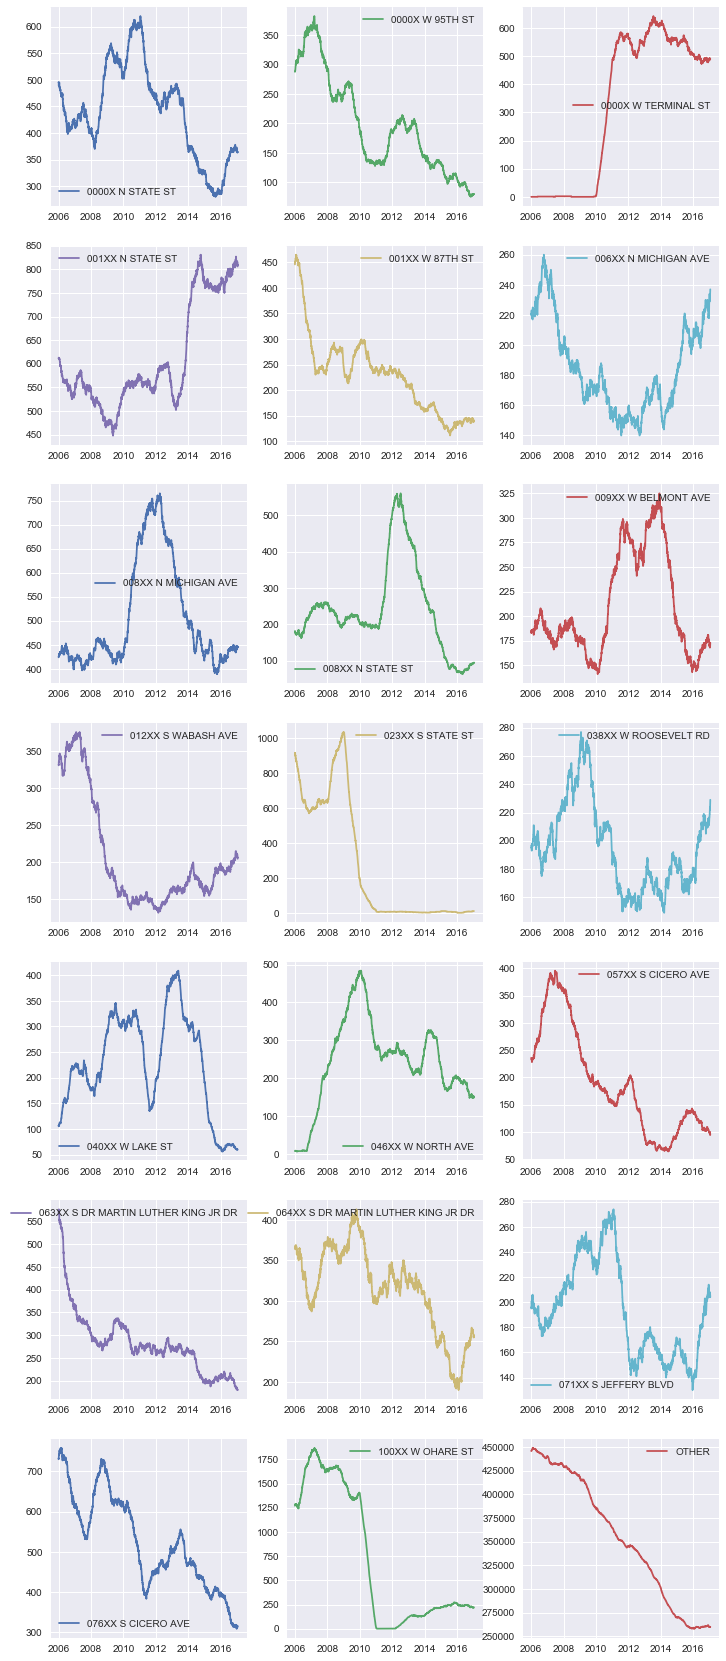

In [19]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Block', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

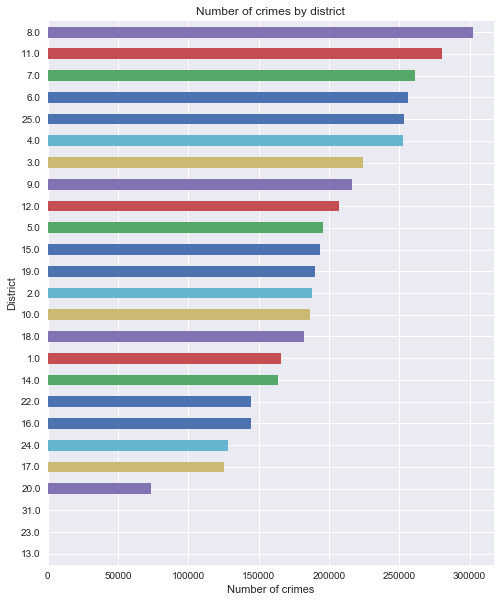

In [20]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['District']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by district')
plt.ylabel('District')
plt.xlabel('Number of crimes')
plt.show()

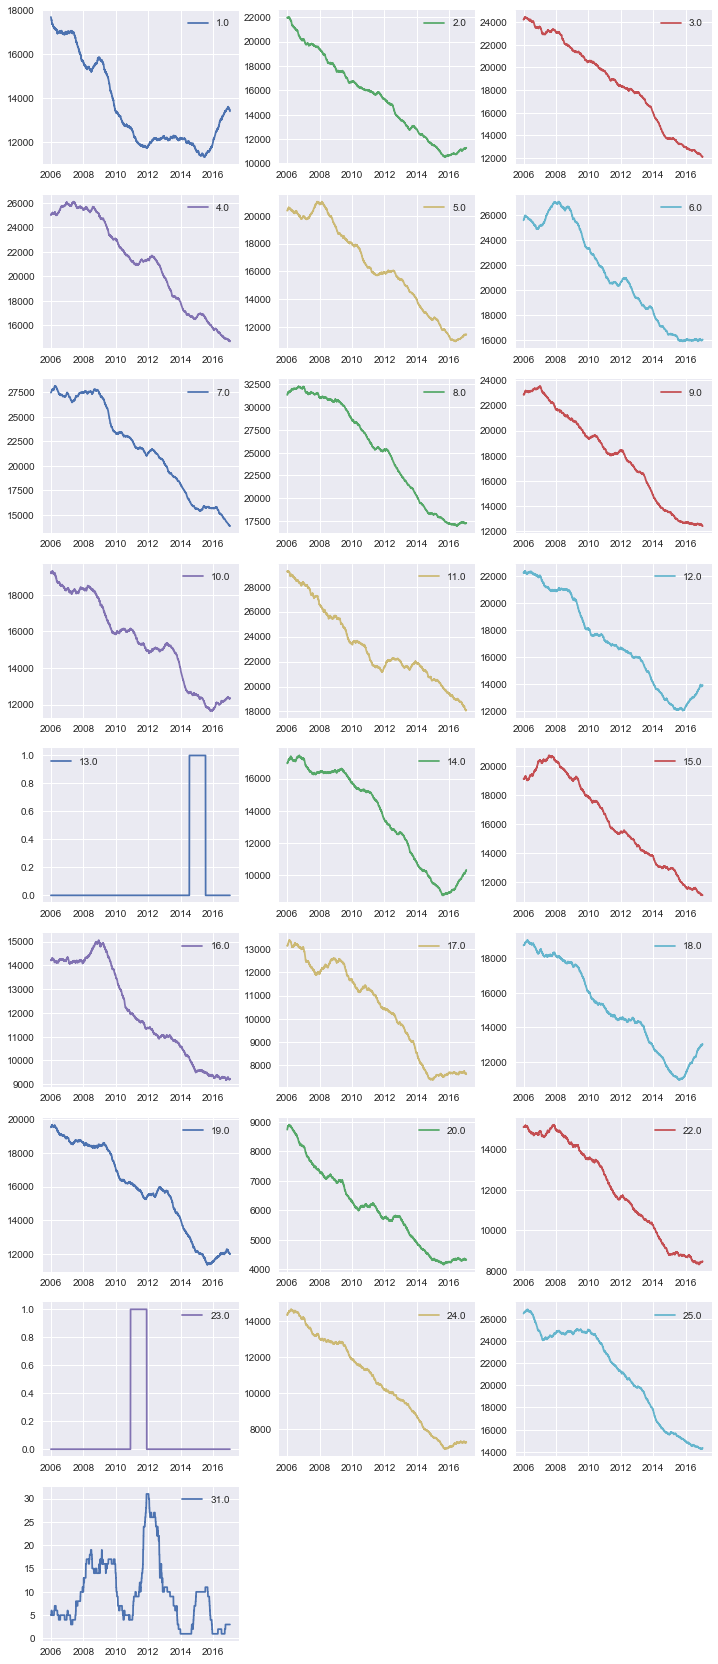

In [21]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='District', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

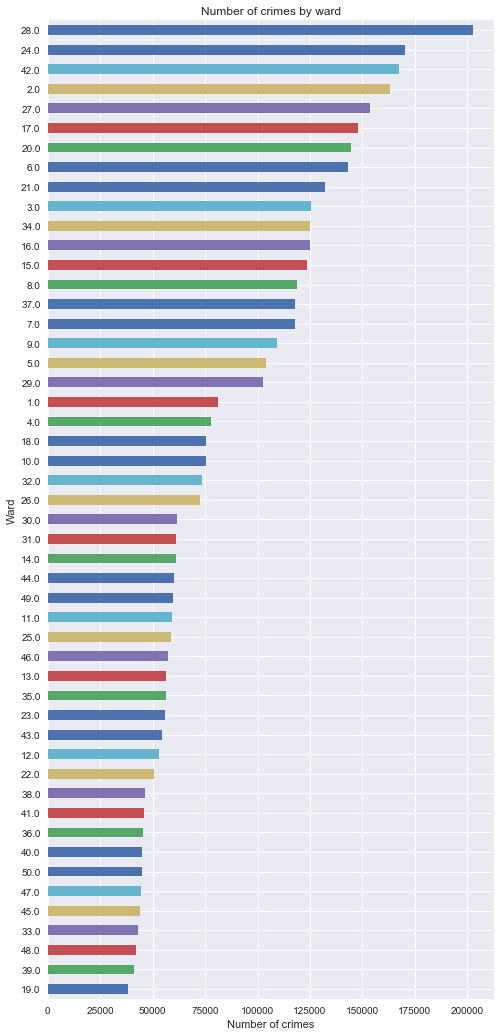

In [22]:
plt.figure(figsize=(8,18))
crimes.groupby([crimes['Ward']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by ward')
plt.ylabel('Ward')
plt.xlabel('Number of crimes')
plt.show()

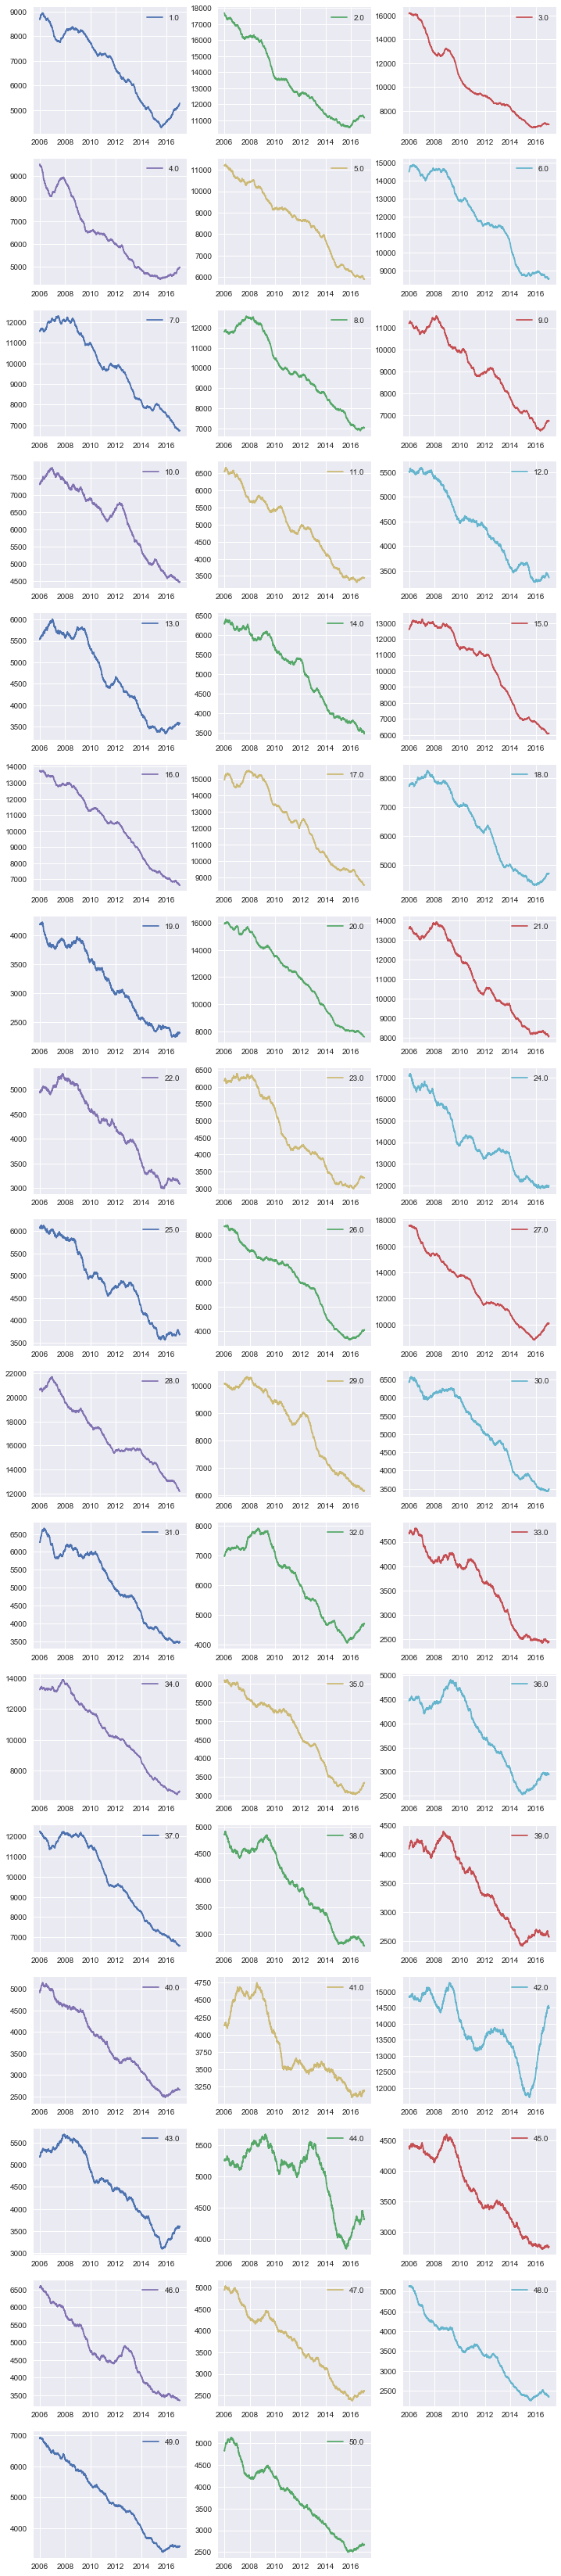

In [28]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Ward', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 60), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

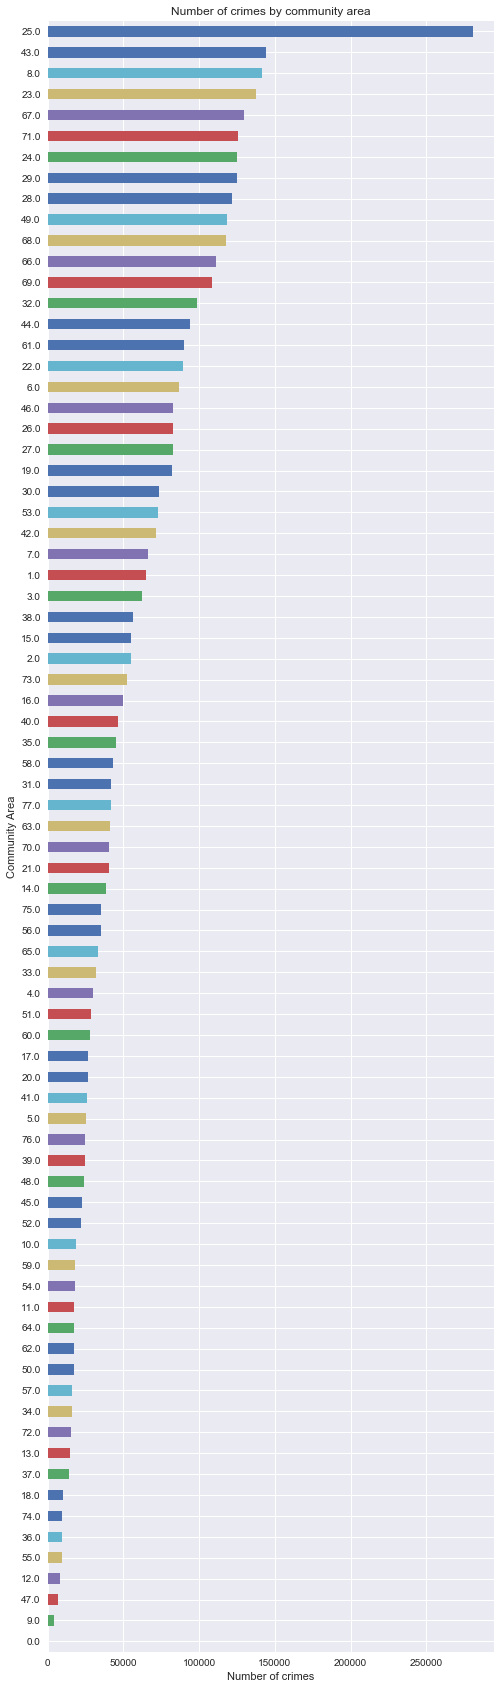

In [25]:
plt.figure(figsize=(8,30))
crimes.groupby([crimes['Community Area']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by community area')
plt.ylabel('Community Area')
plt.xlabel('Number of crimes')
plt.show()

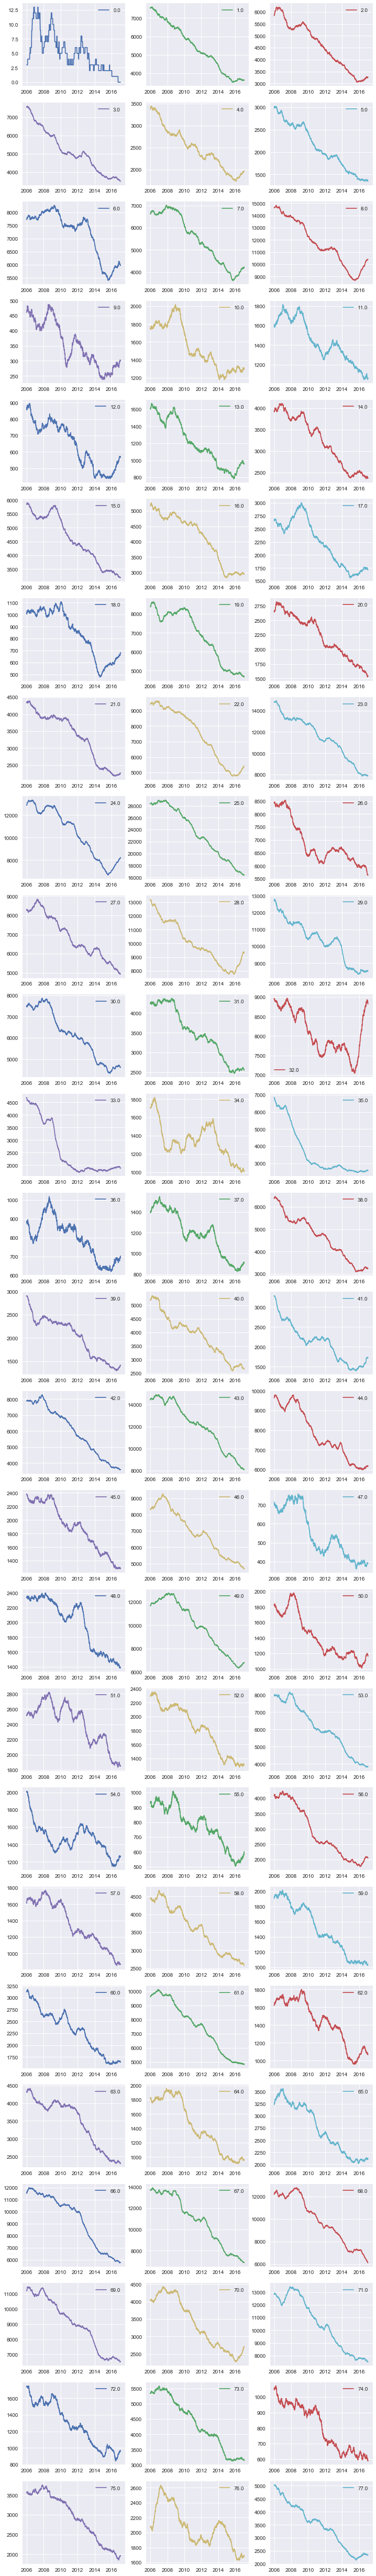

In [27]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Community Area', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 90), subplots=True, layout=(-1, 3), sharex=False, sharey=False)